<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/cats_dogs_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Utilities to upload files
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


In [0]:
#Authorize Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#download train and test images
download = drive.CreateFile({'id': '1EVPUykY4KwHvWL-umtLhJIfGhCFtHqn8'})
download.GetContentFile('train.zip')
download = drive.CreateFile({'id': '1l4vKliu1LB5Y65ZMvsSDrJiPG2mKvdqN'})
download.GetContentFile('test1.zip')

#Extract files
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tmp')
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [0]:
def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

In [0]:
TRAININNG_DIRECTORY='tmp/train'
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

df = pd.DataFrame({'filename': os.listdir(TRAININNG_DIRECTORY)})

df['category'] = df['filename'].map(lambda file_name: file_name.split('.')[0])
df['Y'] = df['category'].map(lambda x: np.array([0,1]) if x =='cat' else np.array([1,0]))
df['X'] = df['filename'].map(lambda file: get_im_cv2(TRAININNG_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)


In [20]:
#build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

#base_model = ResNet50(weights='imagenet', include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

for layer in base_model.layers:
    layer.trainable = False

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)              

In [18]:
#Build Alex Net
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD

# Here, we use a larger 11 x 11 window to capture objects. At the same time,
# we use a stride of 4 to greatly reduce the height and width of the output.
# Here, the number of output channels is much larger than that in LeNet
model = Sequential([
                    Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=3, strides=2, padding='valid'),
                    Conv2D(256, kernel_size=5, padding='valid', strides=1 ,activation='relu'),
                    MaxPooling2D(pool_size=3, strides=2, padding='valid'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    MaxPooling2D(pool_size=3, strides=2),
                    Flatten(),
                    #Dense(4096, activation="relu"), 
                    #BatchNormalization(),
                    #Dropout(0.5),
                    Dense(4096, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(2, activation='softmax')])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 384)        

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=30
BATCH_SIZE=15
callbacks = [learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    ,callbacks=callbacks)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 80s 4ms/step - loss: 0.2328 - acc: 0.9119 - val_loss: 0.0680 - val_acc: 0.9750
Epoch 2/30
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1526 - acc: 0.9439 - val_loss: 0.0599 - val_acc: 0.9788
Epoch 3/30
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1213 - acc: 0.9544 - val_loss: 0.0568 - val_acc: 0.9782
Epoch 4/30
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1022 - acc: 0.9616 - val_loss: 0.0556 - val_acc: 0.9780
Epoch 5/30
20000/20000 [==============================] - 78s 4ms/step - loss: 0.0930 - acc: 0.9654 - val_loss: 0.0553 - val_acc: 0.9778
Epoch 6/30
20000/20000 [==============================] - 78s 4ms/step - loss: 0.0889 - acc: 0.9697 - val_loss: 0.0529 - val_acc: 0.9796
Epoch 7/30
20000/20000 [==============================] - 77s 4ms/step - loss: 0.0792 - acc: 0.9698 - val_loss: 0.0517 - val_acc:

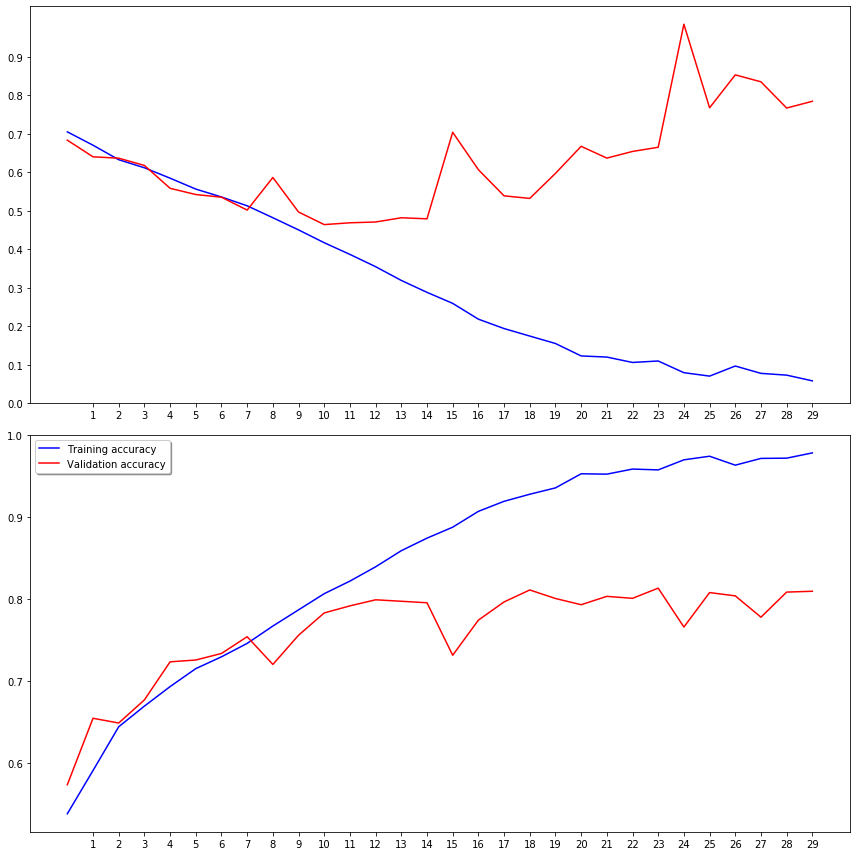

In [11]:
#Plot the loss
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
TEST_DIRECTORY = 'tmp/test1'
test_data_frame = pd.DataFrame({'filename': os.listdir(TEST_DIRECTORY)})

#df['category'] = df['filename'].map(lambda file_name: file_name.split('.')[0])
#df['Y'] = df['category'].map(lambda x: np.array([1,0])if x !='cat' else np.array([0,1]))
test_data_frame['X'] = test_data_frame['filename'].map(lambda file: get_im_cv2(TEST_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

In [0]:
x_perf=[]
for item in test_data_frame['X']:
  x_perf.append(item)

x_perf = np.array(x_perf, dtype=np.uint8)
predict = model.predict(x_perf)

In [14]:
print(predict[0])
print(predict[1])
print(predict[2])
test_data_frame['category'] = np.argmax(predict, axis=1)
label_map = { 0:'dog', 1:'cat'}
test_data_frame['animal'] = test_data_frame['category'].map(lambda x: label_map.get(x))
test_data_frame.head()

[9.9984848e-01 1.5150497e-04]
[1.8785602e-07 9.9999976e-01]
[0.9759192  0.02408086]


,filename,X,category,animal
0,7734.jpg,"[[[64, 85, 107], [65, 86, 107], [65, 86, 107],...",0,dog
1,11301.jpg,"[[[91, 82, 163], [91, 82, 163], [91, 82, 163],...",1,cat
2,7885.jpg,"[[[196, 196, 191], [197, 195, 192], [194, 193,...",0,dog
3,3468.jpg,"[[[85, 129, 106], [97, 136, 111], [100, 131, 1...",0,dog
4,1422.jpg,"[[[111, 127, 143], [109, 126, 142], [108, 127,...",1,cat


ValueError: ignored

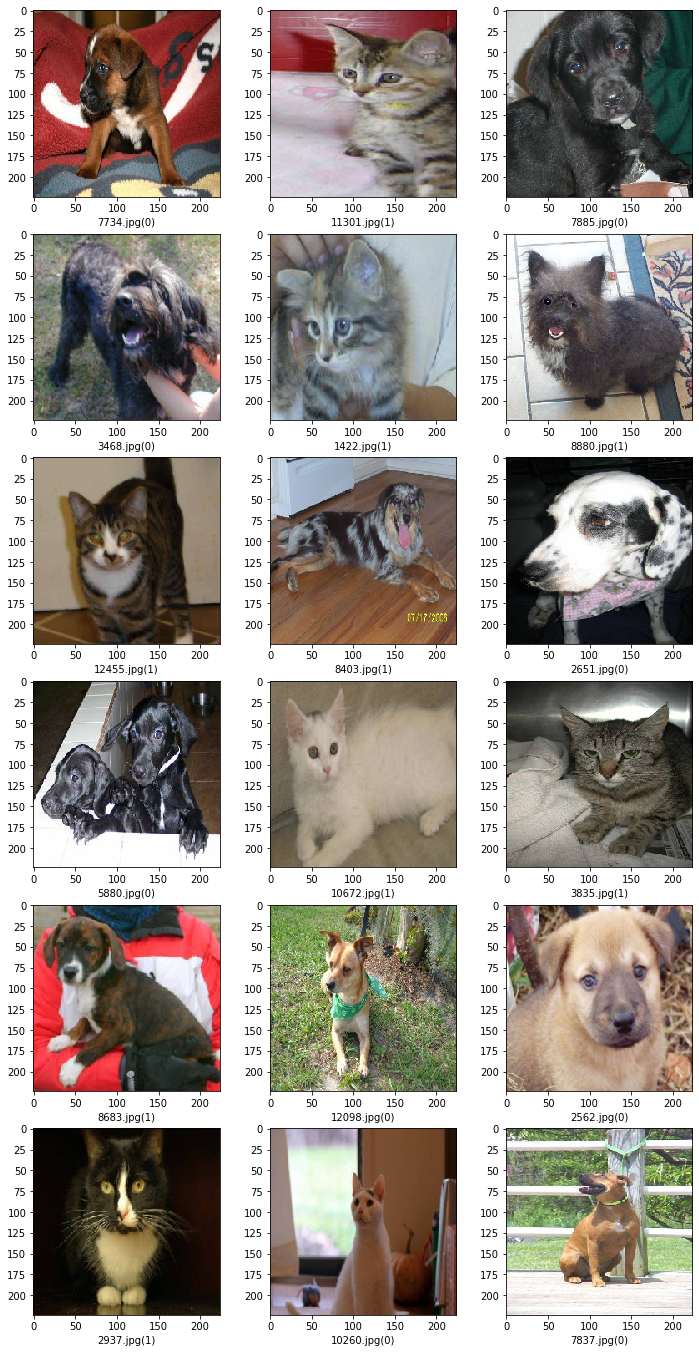

In [15]:
#Draw predictions with images
from keras.preprocessing.image import load_img
sample_test = test_data_frame.head(19)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("tmp/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()